In [76]:
import h5py
import pandas as pd
import numpy as np
import tqdm as trange
from scipy.stats import zscore
import urllib.request
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot
import feather
from IPython.display import display_html, HTML

In [5]:
gene = "DPM1"
f = h5py.File("tcga.hdf5", "r")
tcga_cor = f['full correlation matrix']
tcga_genes = [str(g[0])[2:-1] for g in f['meta']['genes']]
archs4_cor = feather.read_dataframe("human_correlation")
archs4_genes = list(archs4_cor.columns) 
libraries = ['KEGG_2019_Human', 'GO_Biological_Process_2018', 'MGI_Mammalian_Phenotype_Level_4_2019', 
             'ChEA_2016', 'KEA_2015', 'UK_Biobank_GWAS_v1', 'Genes_Associated_with_NIH_Grants']

In [87]:
def display_side_by_side(df1, df2):
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('TCGA')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('ARCHS4')
    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

# Process 

In [88]:
def process(current_lib, tcga_genes, tcga_cor, archs4_genes, archs4_cor):
    pheno_to_genes, gene_set = gene_set_dictionaries(current_lib)
    binary_matrix = gs_binary_matrix(pheno_to_genes, gene_set)
    cor = correlation_matrix(binary_matrix)
    gslib = gene_set_library(cor, pheno_to_genes)
    tcga_pred_matrix = prediction_matrix(gene, tcga_cor, tcga_genes, gslib)
    archs4_pred_matrix = prediction_matrix(gene, archs4_cor, archs4_genes, gslib)
    top_tcga_phenotypes = get_top_phenotypes(tcga_pred_matrix, gene)
    top_archs4_phenotypes = get_top_phenotypes(archs4_pred_matrix, gene)
    if gene in gene_set: auc(binary_matrix.loc[gene], tcga_pred_matrix, archs4_pred_matrix, gene)
    else: print("Not enough gene annotations available.")
    display_side_by_side(top_tcga_phenotypes, top_archs4_phenotypes)


def gene_set_dictionaries(library):
    """
    Given a gene set library, extract a gene set dictionary from Enrichr
    with (phenotypes, genes) and a sorted set of genes
    """
    enrichr_url = 'https://amp.pharm.mssm.edu/Enrichr/geneSetLibrary?mode=text&libraryName='
    data = urllib.request.urlopen(enrichr_url + library) 
    pheno_to_genes = {}
    gene_set = set()
    for line in data:
        lst = (str(line.strip())[2:-1]).split(r'\t')
        phenotype = lst[0]
        genes = lst[2:]
        pheno_to_genes[phenotype] = genes
        gene_set.update(set(genes))
    return pheno_to_genes, sorted(gene_set)


def gs_binary_matrix(pheno_to_genes, gene_set): 
    """
    Given the phenotype to gene dictionary and a set of genes, create a binary matrix
    with genes as rows and phenotypes as columns
    """
    binary_matrix = np.zeros((len(gene_set), len(pheno_to_genes)))
    binary_matrix = pd.DataFrame(data=binary_matrix, index=gene_set, columns=list(pheno_to_genes.keys()))
    for pheno in binary_matrix.columns: 
        gene_list = pheno_to_genes[pheno]
        binary_matrix.loc[gene_list, pheno] += 1
    return binary_matrix


def correlation_matrix(binary_matrix):
    """
    Return correlation matrix in which the diagonal is zero
    """
    genes = list(binary_matrix.index)
    cor = np.corrcoef(binary_matrix)
    np.fill_diagonal(cor, None)
    return pd.DataFrame(data=cor, index=genes, columns=genes)


def gene_set_library(cor, pheno_to_genes):
    """
    Return the gene set library matrix such that for every gene, phenotype,
    you get the correlation of that gene to every other gene in that gene set.
    """
    gslib = np.zeros((len(cor.index)))
    gslib = pd.DataFrame(data=gslib, index=list(cor.index))
    preds = []
    for phenotype in pheno_to_genes:
        genes = pheno_to_genes[phenotype]
        preds.append(cor.loc[:, genes].mean(axis=1))
    gslib = pd.concat(preds, axis=1)
    gslib.columns = list(pheno_to_genes.keys())
    return gslib


def prediction_matrix(gene, cor_mat, list_genes, gslib): 
    """
    Returns the prediction matrix generated from the TCGA/ARCHS4 correlation matrix and the gene 
    set library.
    """
    gene_set = set(list_genes)
    ex_gslib = np.zeros((len(list_genes), len(gslib.columns)))
    ex_gslib = pd.DataFrame(data=ex_gslib, index=list_genes, columns=gslib.columns)
    lib_genes = list(gslib.index)
    for g in lib_genes:
        if g in gene_set: ex_gslib.loc[g] = gslib.loc[g]
    gene_idx = np.where(np.transpose(list_genes) == gene)[0][0]
    pred_matrix = np.dot(cor_mat[gene_idx], ex_gslib)
    if gene in gslib.index: 
        gslib = gslib.drop(index=gene)
    pheno_sums = np.array(np.sum(gslib))
    pred_matrix /= pheno_sums 
    return pd.DataFrame(data=np.transpose(pred_matrix), index=gslib.columns, columns=[gene])


def get_top_phenotypes(pred_matrix, gene):
    """
    Returns the top 50 most correlated phenotypes associated with the given gene and their 
    z-scores.
    """
    top = pred_matrix.sort_values(by=gene, ascending=False).head(50)
    z_scores = pd.DataFrame(zscore(top[gene]), index=top.index)
    genes = pd.DataFrame(list(top.index), index=top.index)
    top = pd.concat([genes, top, z_scores], axis=1)
    top.index = list(range(1,51))
    top.columns = ["Annotation", "Score", "Z-Score"]
    return top
    

def auc(y_true, tcga_probs, archs4_probs, gene):
    ns_probs = [0 for _ in range(len(y_true))]
    fpr, tpr, _ = roc_curve(y_true, tcga_probs)
    apr, bpr, _ = roc_curve(y_true, archs4_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
    tcga_auc = roc_auc_score(y_true, tcga_probs)
    archs4_auc = roc_auc_score(y_true, archs4_probs)
    pyplot.figure(figsize=(11,5))
    pyplot.subplot(1,2,1)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(fpr, tpr, marker='.')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("TCGA: " + gene)
    pyplot.text(0.75, 0.05, 'AUC: %.3f' % tcga_auc, fontsize=12)
    
    pyplot.subplot(1,2,2)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
    pyplot.plot(apr, bpr, marker='.')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title("ARCHS4: " + gene)
    pyplot.text(0.75, 0.05, 'AUC: %.3f' % archs4_auc, fontsize=12)
    pyplot.tight_layout()
    pyplot.show()

# Predicted pathways (KEGG)

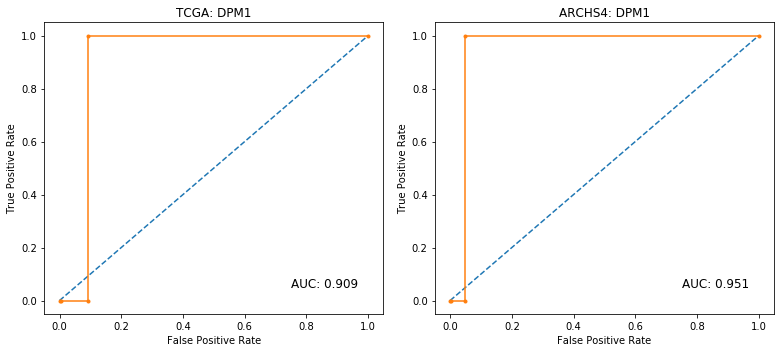

,Annotation,Score,Z-Score
1,Glycosaminoglycan degradation,4.296435,6.055791
2,Carbohydrate digestion and absorption,1.641673,1.997429
3,Proteasome,1.459400,1.718786
4,Fanconi anemia pathway,1.096565,1.164117
5,PPAR signaling pathway,0.845168,0.779803
6,Basal transcription factors,0.556007,0.337760
7,Sphingolipid metabolism,0.458070,0.188043
8,Drug metabolism,0.390782,0.085180
9,Other glycan degradation,0.317393,-0.027011
10,Lysine degradation,0.284312,-0.077582


In [89]:
process(libraries[0], tcga_genes, tcga_cor, archs4_genes, np.array(archs4_cor))

# Predicted biological process (GO_BP)

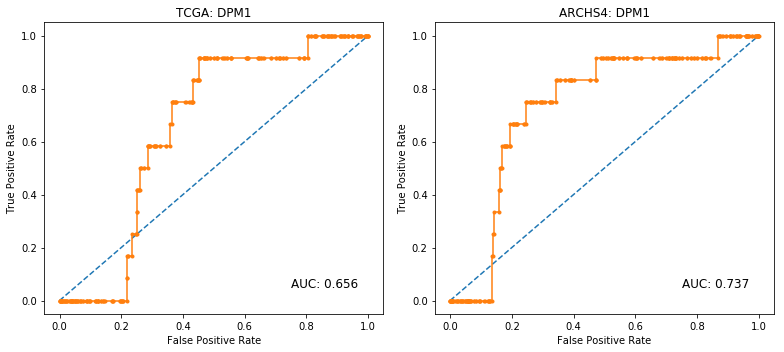

,Annotation,Score,Z-Score
1,L-phenylalanine catabolic process (GO:0006559),1.030049,3.552000
2,erythrose 4-phosphate/phosphoenolpyruvate family amino acid catabolic process (GO:1902222),1.030049,3.552000
3,L-phenylalanine metabolic process (GO:0006558),1.030049,3.552000
4,tRNA pseudouridine synthesis (GO:0031119),0.584728,1.417603
5,nucleotide phosphorylation (GO:0046939),0.523781,1.125489
6,centromeric sister chromatid cohesion (GO:0070601),0.510596,1.062290
7,pyrimidine nucleoside catabolic process (GO:0046135),0.489639,0.961846
8,kynurenine metabolic process (GO:0070189),0.316744,0.133170
9,tRNA 3'-end processing (GO:0042780),0.295315,0.030464
10,mitochondrial tRNA modification (GO:0070900),0.274635,-0.068657


In [90]:
process(libraries[1], tcga_genes, tcga_cor, archs4_genes, np.array(archs4_cor))

# Predicted mouse phenotypes (MGI)

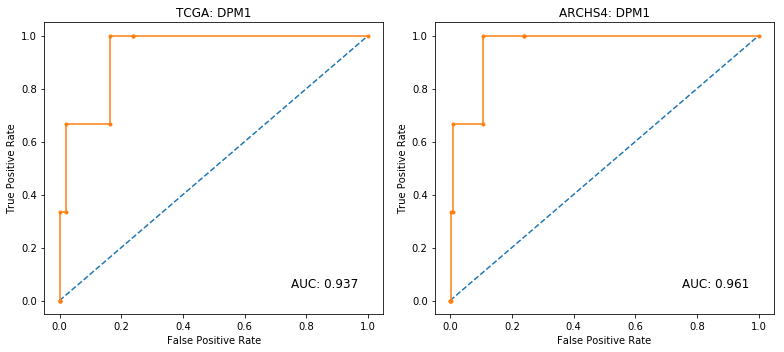

,Annotation,Score,Z-Score
1,MP:0012111 failure of morula compaction,0.088396,3.887991
2,MP:0004966 abnormal inner cell mass proliferation,0.083551,3.377832
3,MP:0012142 absent amniotic cavity,0.066617,1.594429
4,MP:0013292 embryonic lethality prior to organogenesis,0.065586,1.485868
5,MP:0011198 absent proamniotic cavity,0.064787,1.401772
6,MP:0011190 thick embryonic epiblast,0.059739,0.870181
7,MP:0012119 increased trophectoderm apoptosis,0.057839,0.670091
8,MP:0013987 absent intrahepatic inferior vena cava segment,0.057635,0.648542
9,MP:0011208 small proamniotic cavity,0.057015,0.583250
10,MP:0013952 retro-esophageal left subclavian artery,0.056781,0.558700


In [91]:
process(libraries[2], tcga_genes, tcga_cor, archs4_genes, np.array(archs4_cor))

# Predicted upstream transcription factors (ChEA)

In [333]:
process(libraries[3])

# Predicted UK Biobank phenotype

In [ ]:
process(libraries[4])

# Predicted NIH grant phenotypes

In [ ]:
process(libraries[5])